In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import cvxpy as cp
import pandas as pd
from networkx.algorithms.flow import edmonds_karp
import random
import itertools
from copy import deepcopy

# Exercise 1

In [2]:
# Graph creation
G1 = nx.DiGraph()
G1.add_edges_from([
    ('o', 'a', {'capacity':3, 'key':'e1'}),
    ('o', 'b', {'capacity':3, 'key':'e3'}),
    ('a', 'b', {'capacity':1, 'key':'e6'}),
    ('b', 'c', {'capacity':3, 'key':'e4'}),
    ('a', 'd', {'capacity':3, 'key':'e2'}),
    ('c', 'd', {'capacity':2, 'key':'e5'})
])

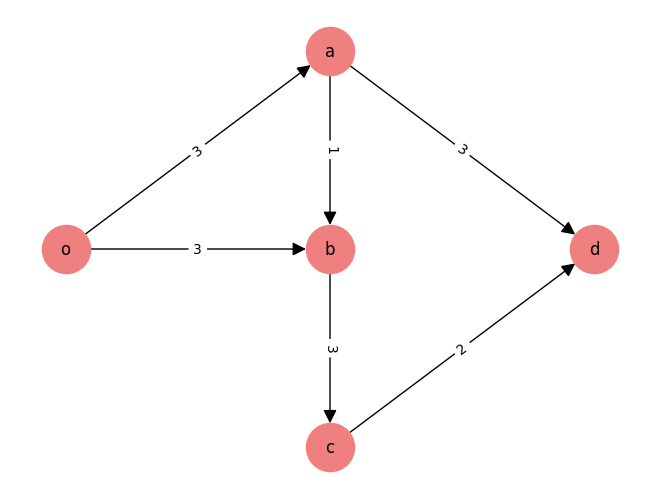

<Figure size 800x500 with 0 Axes>

In [3]:
pos = {'o': [0,1], 'a': [1,2], 'b': [1,1], 'c': [1,0], 'd': [2,1]}
nx.draw(G1, pos, with_labels=True, node_color='lightcoral', node_size=1200, arrows = True, arrowsize=20)

edge_labels = nx.get_edge_attributes(G1, 'capacity')
nx.draw_networkx_edge_labels(G1, pos, edge_labels=edge_labels)
plt.figure(figsize=(8, 5))
plt.show()

#### (a) Compute the capacity of all the cuts and find the minimum capacity to be removed for no feasible flow from $o$ to $d$ to exist

**Answer:** Considering the small size of the graph, all cut capacities have been computed manually. The complete list of cuts and their corresponding capacities is report in the Report. To validate our results, we also verified the minimum cut and the maximum throughput using the NetworkX functions: `networkx.algorithms.flow.minimum_cut` and `networkx.algorithms.flow.maximum_flow`

In [4]:
#finding the minimum cut
nx.algorithms.flow.minimum_cut(G1,'o','d')

(5, ({'a', 'b', 'c', 'o'}, {'d'}))

In [5]:
#finding the maximum flow
nx.algorithms.flow.maximum_flow(G1,'o','d')

(5,
 {'o': {'a': 3, 'b': 2},
  'a': {'b': 0, 'd': 3},
  'b': {'c': 2},
  'c': {'d': 2},
  'd': {}})

#### (b) You are given $x > 0$ extra units of capacity $(x \in \Z)$. How should you distribute them in order to maximize the throughput that can be sent from $o$ to $d$?
Plot the maximum throughput from $o$ to $d$ as a function of $x \geq 0$

**Answer:** We adopted an incremental allocation approach that is explained in the Report.

In [ ]:
# return the total capacity and edge list for the cut (U, V\U)
def cut_capacity_and_edges(G: nx.DiGraph, U: set, cap: str = 'capacity'):
    T = set(G.nodes()) - U
    cap_sum = 0
    cut_edges = []
    for u in U:
        for v in G.successors(u):
            if v in T:
                w = G[u][v].get(cap, 0)
                cap_sum += w
                cut_edges.append((u, v))
    return cap_sum, tuple(cut_edges)


# enumerate all possible subsets
def enumerate_valid_cuts(G: nx.DiGraph, s, t, cap: str = 'capacity'):
    nodes = list(G.nodes())
    nodes.remove(s)
    if t in nodes:
        nodes.remove(t)

    valid_cuts = []
    # Generate all combinations of remaining nodes
    for r in range(len(nodes) + 1):
        for subset in itertools.combinations(nodes, r):
            U = set(subset) | {s}
            if t in U:
                continue
            cap_sum, edges = cut_capacity_and_edges(G, U, cap=cap)
            valid_cuts.append({'U': U, 'cap': cap_sum, 'edges': edges})
    return valid_cuts


# count how often each edge appears in the list of min-cuts
def edge_frequency_in_cuts(min_cuts):
    freq = {}
    for c in min_cuts:
        for e in c['edges']:
            freq[e] = freq.get(e, 0) + 1
    return freq


# choose the edge to increase according to the described rules
def choose_edge_to_increase(min_cuts, rng: random.Random | None = None):
    if not min_cuts:
        return None
    if rng is None:
        rng = random

    # if all min-cuts share common edges, choose one of them
    edge_sets = [set(c['edges']) for c in min_cuts]
    common = set.intersection(*edge_sets) if edge_sets else set()
    if common:
        return rng.choice(sorted(list(common)))

    # otherwise choose the edge that appears in the most min-cuts
    freq = edge_frequency_in_cuts(min_cuts)
    if not freq:
        return None
    max_count = max(freq.values())
    candidates = [e for e, c in freq.items() if c == max_count]
    # if tie, pick one randomly among the most frequent
    return rng.choice(sorted(candidates))

# find all the minimum cuts
def find_min_cuts(G: nx.DiGraph, s, t, cap: str = 'capacity'):
    cuts = enumerate_valid_cuts(G, s, t, cap=cap)
    if not cuts:
        return None, []
    cuts.sort(key=lambda c: (c['cap'], sorted(c['U'])))
    min_cap = cuts[0]['cap']
    min_cuts = [c for c in cuts if c['cap'] == min_cap]
    return min_cap, min_cuts


# capacities allocation
def allocate_extra_capacity_iterative(
    G_in: nx.DiGraph, s, t, x: int, cap: str = 'capacity',
    seed: int | None = None, verbose: bool = True
):
    
    G = deepcopy(G_in)
    rng = random.Random(seed) if seed is not None else random

    throughputs = []
    v0, _ = nx.maximum_flow(G, s, t, capacity=cap)
    throughputs.append(v0)
    if verbose:
        print(f"[x=0] max throughput = {v0}")

    history = []
    for i in range(1, x + 1):
        min_cap, min_cuts = find_min_cuts(G, s, t, cap=cap)
        edge = choose_edge_to_increase(min_cuts, rng=rng)
        if edge is None:
            history.append({'step': i, 'min_cap': min_cap, 'increased': None, 'flow': throughputs[-1]})
            if verbose:
                print(f"[x={i}] no edge to increase; flow stays {throughputs[-1]}")
            continue

        # increment the chosen edge
        u, v = edge
        G[u][v][cap] = G[u][v].get(cap, 0) + 1
        v_now, _ = nx.maximum_flow(G, s, t, capacity=cap)
        throughputs.append(v_now)
        history.append({'step': i, 'min_cap': min_cap, 'increased': (u, v), 'flow': v_now})

        if verbose:
            print(f"[x={i}] min-cut={min_cap}  +1 on {edge}  -> max throughput = {v_now}")

    return G, history, throughputs

# plot function
def plot_throughput(throughputs, title="Max throughput vs Extra capacity units"):
    xs = list(range(len(throughputs)))
    plt.figure()
    plt.step(xs, throughputs, where='post')
    plt.xlabel("Extra capacity units")
    plt.ylabel("Maximum throughput")
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.4)

    y_min = 0
    y_max = max(throughputs)
    plt.ylim(y_min, y_max + 1)
    plt.yticks(range(y_min, y_max + 1, 1))
    
    plt.show()

[x=0] max throughput = 5
[x=1] min-cut=5  +1 on ('c', 'd')  -> max throughput = 6
[x=2] min-cut=6  +1 on ('o', 'a')  -> max throughput = 6
[x=3] min-cut=6  +1 on ('a', 'd')  -> max throughput = 7
[x=4] min-cut=7  +1 on ('o', 'a')  -> max throughput = 7
[x=5] min-cut=7  +1 on ('a', 'd')  -> max throughput = 8
[x=6] min-cut=8  +1 on ('o', 'a')  -> max throughput = 8
[x=7] min-cut=8  +1 on ('a', 'd')  -> max throughput = 9
[x=8] min-cut=9  +1 on ('o', 'a')  -> max throughput = 9
[x=9] min-cut=9  +1 on ('a', 'd')  -> max throughput = 10
[x=10] min-cut=10  +1 on ('o', 'a')  -> max throughput = 10
[x=11] min-cut=10  +1 on ('a', 'd')  -> max throughput = 11
[x=12] min-cut=11  +1 on ('o', 'a')  -> max throughput = 11
[x=13] min-cut=11  +1 on ('a', 'd')  -> max throughput = 12
[x=14] min-cut=12  +1 on ('o', 'a')  -> max throughput = 12
[x=15] min-cut=12  +1 on ('a', 'd')  -> max throughput = 13
[x=16] min-cut=13  +1 on ('o', 'a')  -> max throughput = 13
[x=17] min-cut=13  +1 on ('a', 'd')  -> m

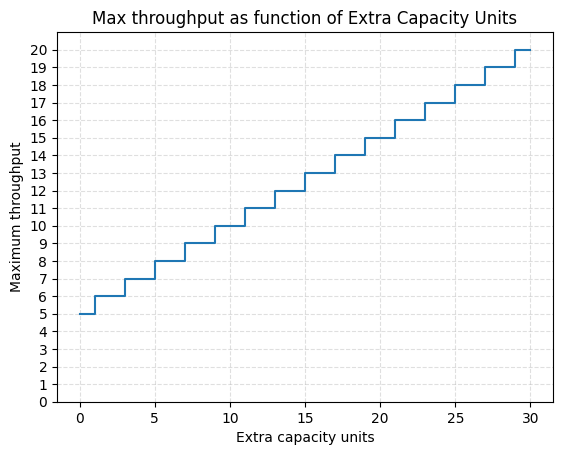

In [ ]:
s, t = 'o', 'd'
# extra capacity units to allocate
x = 30

G_final, history, F = allocate_extra_capacity_iterative(G1, s, t, x=x, seed=42, verbose=True)

print("\nHistory of increments:")
for h in history:
    print(h)

plot_throughput(F, title="Max throughput as function of Extra Capacity Units")

#### (c) You are given the possibility of adding to the network a directed link e8 with capacity $c8 = 1$ and $x > 0$ extra units of capacity $(x \in \Z)$. Where should you add the link and how should you distribute the additional capacity in order to maximize the throughput that can be sent from $o$ to $d$?
Plot the maximum throughput from $o$ to $d$ as a function of $x \geq 0$

**Answer**: The most straightforward solution is to introduce a direct link between $o$ and $d$, introducing the whole capacity in it. It would intuitively act as an "highway" of flow.

In [ ]:
def compute_Fmax_linear_with_e8(G_base, X_max=30, c8_base=1):
    s, t = 'o', 'd'

    G0 = deepcopy(G_base)
    G0.add_edge('o', 'd', capacity=c8_base)

    F0 = nx.maximum_flow_value(G0, s, t, capacity='capacity')

    x_values = list(range(X_max + 1))
    Fmax = [F0 + x for x in x_values]

    return x_values, Fmax


def plot_Fmax_linear(x_values, Fmax):

    plt.figure(figsize=(10, 6))

    plt.step(x_values, Fmax, where='post', linewidth=2)

    plt.title("Max throughput as function of Extra capacity units", fontsize=12)
    plt.xlabel("Extra capacity units", fontsize=12)
    plt.ylabel("Maximum throughput", fontsize=12)

    x_min, x_max = min(x_values), max(x_values)
    x_step = max(1, (x_max - x_min) // 10)
    plt.xticks(range(x_min, x_max + 1, x_step))

    y_min = 0
    y_max = max(Fmax)
    plt.ylim(y_min, y_max + 1)
    y_step = max(1, (y_max - y_min) // 7)
    plt.yticks(range(y_min, y_max + 1, y_step))

    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


F_max(x) with e8 : o -> d
x =  0  ->  F_max(x) = 6
x =  1  ->  F_max(x) = 7
x =  2  ->  F_max(x) = 8
x =  3  ->  F_max(x) = 9
x =  4  ->  F_max(x) = 10
x =  5  ->  F_max(x) = 11
x =  6  ->  F_max(x) = 12
x =  7  ->  F_max(x) = 13
x =  8  ->  F_max(x) = 14
x =  9  ->  F_max(x) = 15
x = 10  ->  F_max(x) = 16
x = 11  ->  F_max(x) = 17
x = 12  ->  F_max(x) = 18
x = 13  ->  F_max(x) = 19
x = 14  ->  F_max(x) = 20
x = 15  ->  F_max(x) = 21
x = 16  ->  F_max(x) = 22
x = 17  ->  F_max(x) = 23
x = 18  ->  F_max(x) = 24
x = 19  ->  F_max(x) = 25
x = 20  ->  F_max(x) = 26
x = 21  ->  F_max(x) = 27
x = 22  ->  F_max(x) = 28
x = 23  ->  F_max(x) = 29
x = 24  ->  F_max(x) = 30
x = 25  ->  F_max(x) = 31
x = 26  ->  F_max(x) = 32
x = 27  ->  F_max(x) = 33
x = 28  ->  F_max(x) = 34
x = 29  ->  F_max(x) = 35
x = 30  ->  F_max(x) = 36


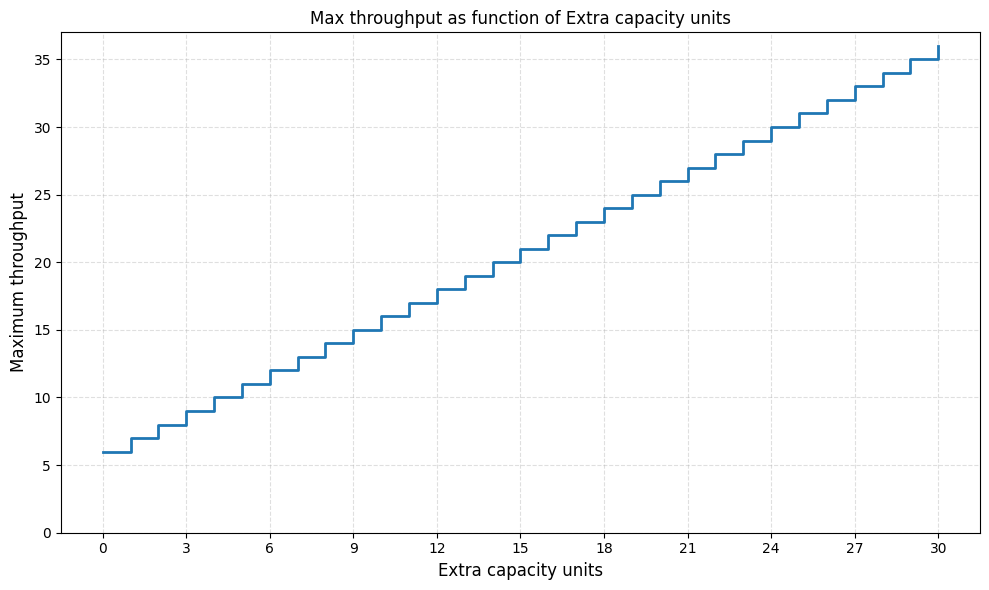

In [15]:
X_max = 30
x_vals_c, Fmax_c = compute_Fmax_linear_with_e8(G1, X_max=X_max, c8_base=1)


print("F_max(x) with e8 : o -> d")
for x_val, f_val in zip(x_vals_c, Fmax_c):
    print(f"x = {x_val:2d}  ->  F_max(x) = {f_val}")

plot_Fmax_linear(x_vals_c, Fmax_c)

# Exercise 2

In [10]:
# Graph creation
G2 = nx.Graph()

clique_nodes = [f"n{i}" for i in range(1, 6)]
for i in range(len(clique_nodes)):
    for j in range(i+1, len(clique_nodes)):
        G2.add_edge(clique_nodes[i], clique_nodes[j])

G2.add_edges_from([
    ("n7", "n8"),
    ("n8", "n9"),
    ("n6", "n15"),
    ("n6", "n1"), 
    ("n6", "n2"), 
    ("n6", "n3"),
    ("n6", "n4"), 
    ("n6", "n5"), 
    ("n6", "n7")
])

for i in range(10, 15):
    G2.add_edge("n9", f"n{i}")

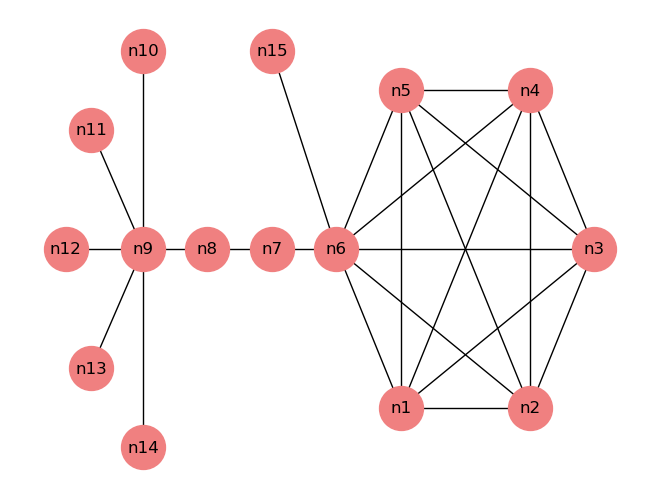

In [54]:
pos = {
    "n1": (2.0, -0.4),
    "n2": (3, -0.4),
    "n3": (3.5, 0.0),
    "n4": (3, 0.4),
    "n5": (2.0, 0.4),
    "n6": (1.5, 0.0),
    "n7": (1.0, 0.0),
    "n8": (0.5, 0.0),
    "n9": (0.0, 0.0),
    "n10": (0.0, 0.5),
    "n11": (-0.4, 0.3),
    "n12": (-0.6, 0.0),
    "n13": (-0.4, -0.3),
    "n14": (0.0, -0.5),
    "n15": (1.0, 0.5)
}

nx.draw(G2, pos, with_labels=True, node_color='lightcoral', node_size=1000)
plt.show()

#### (a) Compute the Katz centrality, with $\beta = 0.15$ and uniform intrinsic centrality $\mu$

In [55]:
# Compute matrices of the graph
W = nx.adjacency_matrix(G2)
W = W.toarray()
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

In [56]:
N = G2.number_of_nodes() 
beta = 0.15
mu = np.ones((N,1))/N

z_0 = np.ones((N,1))/N

# set a tolerance to assess convergence to the limit
tol = 1e-5

In [57]:
# initialize z
z_old = z_0

# Compute radius
eval, evec = np.linalg.eig(W)
eval = eval.real
radius = np.max(eval)


print("Radius of matrix W:"+str(radius))

while True:
    # define update rule of z
    z_new = W.T @ z_old * (1-beta)/radius + beta * mu
    if np.linalg.norm(z_new-z_old) < tol:
        break
    z_old=z_new

zk_distr = z_new

# normalize the centrality
zk_distr = zk_distr / sum(zk_distr)

zip_iterator = zip(G2.nodes(), zk_distr)
zb_dict = dict(zip_iterator)

print("Katz centrality:")
for key, value in zb_dict.items():
    print(f"{key}: {value}")

Radius of matrix W:5.071061467321913
Katz centrality:
n1: [0.11813757]
n2: [0.11813757]
n3: [0.11813757]
n4: [0.11813757]
n5: [0.11813757]
n7: [0.04424685]
n8: [0.03172152]
n9: [0.04281285]
n6: [0.13007854]
n15: [0.03892977]
n10: [0.02430452]
n11: [0.02430452]
n12: [0.02430452]
n13: [0.02430452]
n14: [0.02430452]


#### (b) Write a distributed algorithm for the computation of Page-rank centrality, with $\beta = 0.15$ and uniform intrinsic centrality $\mu$
$$
z = (\mathbf{I} - (1-\beta) P')^{-1} \beta \mu
$$

In [59]:
z_old = z_0

while True:
    z_new = P.T @ z_old * (1-beta) + beta * mu
    if np.linalg.norm(z_new-z_old) < tol:
        break
    z_old=z_new

zb_distr = z_new

# normalize the centrality
zb_distr = zb_distr / sum(zb_distr)


zip_iterator = zip(G2.nodes(), zb_distr)
zb_dict = dict(zip_iterator)

print("Bonachic centrality: ")
for key, value in zb_dict.items():
    print(f"{key}: {value}")

Bonachic centrality: 
n1: [0.07467977]
n2: [0.07467977]
n3: [0.07467977]
n4: [0.07467977]
n5: [0.07467977]
n7: [0.04861054]
n8: [0.05815016]
n9: [0.19404103]
n6: [0.11445073]
n15: [0.0238975]
n10: [0.03749024]
n11: [0.03749024]
n12: [0.03749024]
n13: [0.03749024]
n14: [0.03749024]


#### (c) Explain the results of points (a) and (b), focusing on the centralities of nodes $n6$ and $n9$


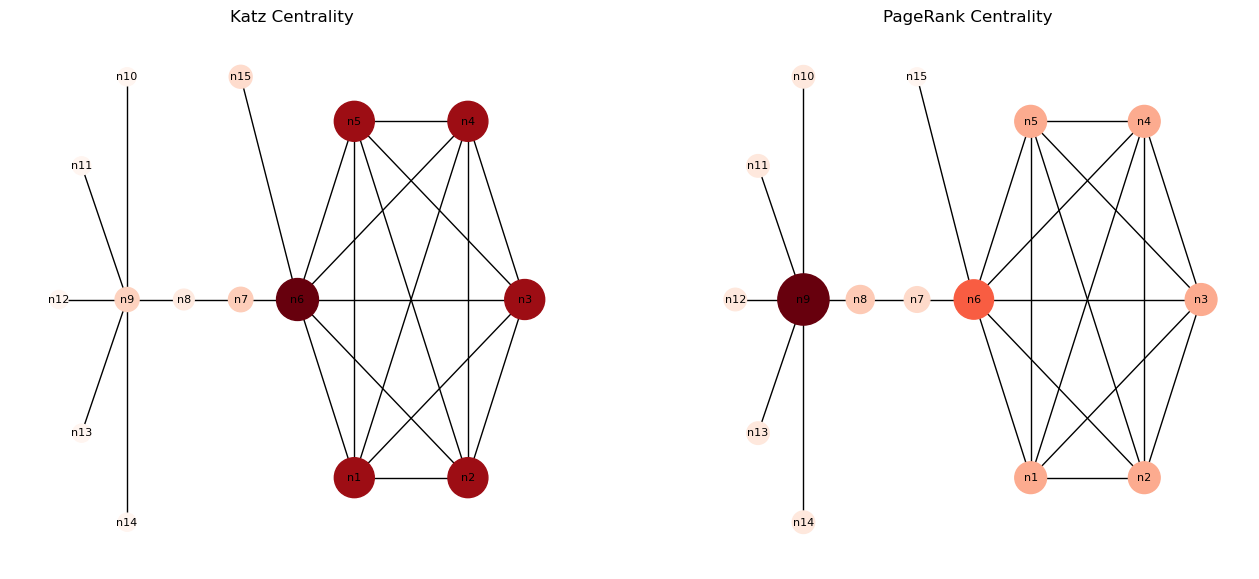

In [18]:
# reshape the centrality vectors and rescale for visualization
zk_reshape = zk_distr.reshape(N)
zb_reshape = zb_distr.reshape(N)
nodesize_k = zk_reshape * 7000
nodesize_b = zb_reshape * 7000



plt.figure(figsize=(16, 7))

# Katz centrality
plt.subplot(1, 2, 1)
nx.draw(
    G2, pos,
    with_labels=True,
    nodelist=list(G2.nodes()),
    node_size=nodesize_k,
    node_color=zk_reshape,
    cmap=plt.cm.Reds,
    font_size=8
)
plt.title("Katz Centrality", fontsize=12)

# PageRank centrality
plt.subplot(1, 2, 2)
nx.draw(
    G2, pos,
    with_labels=True,
    nodelist=list(G2.nodes()),
    node_size=nodesize_b,
    node_color=zb_reshape,
    cmap=plt.cm.Reds,
    font_size=8
)

plt.title("PageRank Centrality", fontsize=12)
plt.show()

#### (d) Compute the Page-Rank centrality with uniform intrinsic centrality $µ$ and for every$$\beta \in \{0,\frac{1}{4},\frac{2}{4},\frac{3}{4},1\} $$

In [19]:
def pagerank_iterative(P, beta, mu, tol=1e-5, max_iter=10000):
    if beta == 1.0:
        return mu.reshape(-1, 1)
    N = len(mu)
    z_old = np.ones((N, 1)) / N
    for _ in range(max_iter):
        z_new = (1 - beta) * (P.T @ z_old) + beta * mu.reshape(N, 1)
        if np.linalg.norm(z_new - z_old, ord=1) < tol:
            return z_new
        z_old = z_new
    return z_old

PageRank(n6) by β: {0.0: 0.14583351917185394, 0.25: 0.11060459536229676, 0.5: 0.10140405981519418, 0.75: 0.08750668778291992, 1.0: 0.06666666666666668}
PageRank(n9) by β: {0.0: 0.12499795017092834, 0.25: 0.19111449763773505, 0.5: 0.16669163847689578, 0.75: 0.12697705298002854, 1.0: 0.06666666666666668}
z[n6]-z[n9] by β: {0.0: 0.020835569000925605, 0.25: -0.08050990227543829, 0.5: -0.0652875786617016, 0.75: -0.039470365197108614, 1.0: 0.0}
Difference z[n6]-z[n9] is NOT monotone in β.


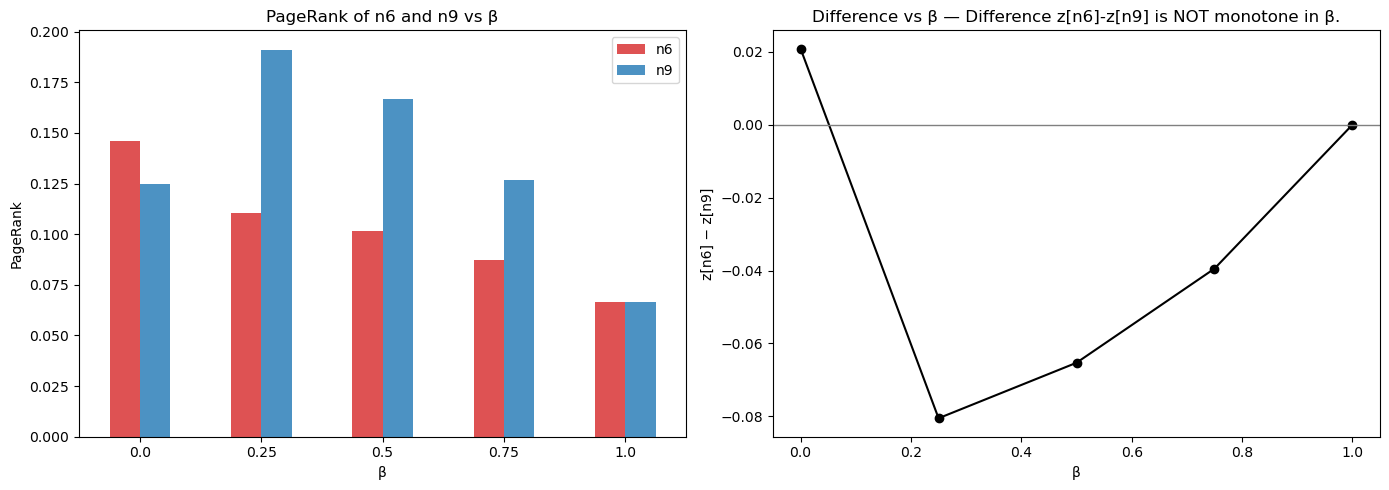

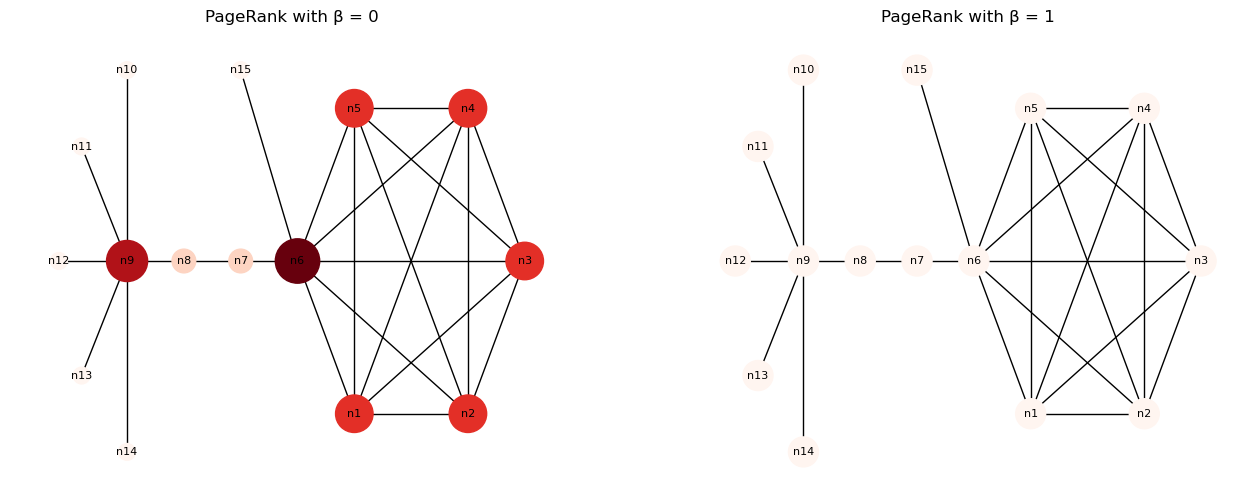

In [ ]:
P = W / degrees[:, None]

betas = np.array([0.0, 0.25, 0.5, 0.75, 1.0])
N = G2.number_of_nodes()
mu = np.ones((N,)) / N


nodes = list(G2.nodes())
idx_n6 = nodes.index("n6")
idx_n9 = nodes.index("n9")
pr_results = {}
n6_vals, n9_vals, diff_vals = [], [], []

# compute PageRank for each β
for b in betas:
    z = pagerank_iterative(P, b, mu)
    z = (z / z.sum()).reshape(-1)
    pr_results[b] = z
    n6_vals.append(float(z[idx_n6]))
    n9_vals.append(float(z[idx_n9]))
    diff_vals.append(float(z[idx_n6] - z[idx_n9]))


# check whether the difference z[n6] - z[n9] is monotone in β
diff_vals = np.array(diff_vals)
eps = 1e-12
is_nondec = np.all(np.diff(diff_vals) >= -eps)
is_noninc = np.all(np.diff(diff_vals) <=  eps)
if is_nondec and not is_noninc:
    monotone_msg = "Difference z[n6]-z[n9] is non-decreasing in β."
elif is_noninc and not is_nondec:
    monotone_msg = "Difference z[n6]-z[n9] is non-decreasing in β."
    monotone_msg = "Difference z[n6]-z[n9] is non-increasing in β."
elif is_nondec and is_noninc:
    monotone_msg = "Difference z[n6]-z[n9] is constant in β."
else:
    monotone_msg = "Difference z[n6]-z[n9] is NOT monotone in β."

print("PageRank(n6) by β:", dict(zip(pd.Series(betas), n6_vals)))
print("PageRank(n9) by β:", dict(zip(pd.Series(betas), n9_vals)))
print("z[n6]-z[n9] by β:", dict(zip(pd.Series(betas), pd.Series(diff_vals))))
print(monotone_msg)

# plot 1
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# plot 1.1
centers = np.arange(len(betas))
group_width = 0.6
bar_width = 0.25
offset = bar_width / 2

x_n6 = centers - offset
x_n9 = centers + offset

ax[0].bar(x_n6, n6_vals, width=bar_width, label="n6", color="tab:red", alpha=0.8)
ax[0].bar(x_n9, n9_vals, width=bar_width, label="n9", color="tab:blue", alpha=0.8)

ax[0].set_xlabel("β")
ax[0].set_ylabel("PageRank")
ax[0].set_title("PageRank of n6 and n9 vs β")
ax[0].set_xticks(centers)
ax[0].set_xticklabels(betas)
ax[0].set_xlim(-0.5, len(betas) - 0.5)
ax[0].legend()

# plot 1.2
ax[1].plot(betas, diff_vals, marker="o", color="black")
ax[1].axhline(0.0, color="gray", linewidth=1)
ax[1].set_xlabel("β")
ax[1].set_ylabel("z[n6] − z[n9]")
ax[1].set_title(f"Difference vs β — {monotone_msg}")

plt.tight_layout()
plt.show()


# plot 2
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
nodesize_0 = 7000 * pr_results[0.0]
nx.draw(G2, pos, with_labels=True, nodelist=nodes, node_size=nodesize_0,
        node_color=pr_results[0.0], cmap=plt.cm.Reds, font_size=8)
plt.title("PageRank with β = 0")
plt.axis("off")

plt.subplot(1, 2, 2)
nodesize_1 = 7000 * pr_results[1.0]
nx.draw(G2, pos, with_labels=True, nodelist=nodes, node_size=nodesize_1,
        node_color=pr_results[1.0], cmap=plt.cm.Reds, font_size=8)
plt.title("PageRank with β = 1")
plt.axis("off")
plt.show()

# Exercise 3

In [21]:
try:
    f = sio.loadmat('flow.mat')["flow"].reshape(28,)
    C = sio.loadmat('capacities.mat')["capacities"].reshape(28,)
    B = sio.loadmat('traffic.mat')["traffic"]
    l = sio.loadmat('traveltime.mat')["traveltime"].reshape(28,)

except FileNotFoundError:
    print("Check that the .mat files are in the current directory")

In [ ]:
#Graph costruction
G3 = nx.DiGraph()
num_nodes, num_edges = B.shape

G3.add_nodes_from(range(1, num_nodes + 1))

# add edges and capacities
for j in range(num_edges):
    src = np.where(B[:, j] == 1)[0][0] +1
    dst = np.where(B[:, j] == -1)[0][0] +1
    G3.add_edge(src, dst, capacity=int(C[j]), travel_time=l[j])

print(f"Graph construction completed:\n{G3.number_of_nodes()} nodes and {G3.number_of_edges()} edges")

Graph construction completed:
17 nodes and 28 edges


In [23]:
def check_non_negative_edges(G):
    for u, v, data in G.edges(data=True):
        if G[u][v]['travel_time'] < 0:
            return False
    return True

In [24]:
check_non_negative_edges(G3)

True

#### Draw the graph

In [25]:
pos = {
    1: (0, 7.5),
    2: (3.5, 7.5),
    3: (6, 7.5),
    4: (8.5, 7.5),
    5: (13, 7.5),
    6: (1.5, 5.5),
    7: (3.5, 5.5),
    8: (6, 5.5),
    9: (8.5, 5.5),
    10: (3.5, 3.5),
    11: (6, 3.5),
    12: (8.5, 3.5),
    13: (11, 3.5),
    14: (13, 3.5),
    15: (6, 1.5),
    16: (8.5, 1.5),
    17: (12.5, 1.5)
}

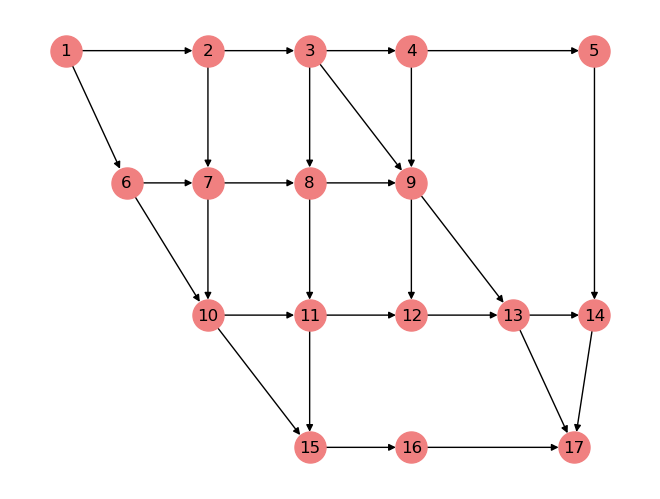

In [26]:
nx.draw(G3, pos, with_labels=True, node_color='lightcoral', node_size=500)
plt.show()

#### (a) Find the shortest path between node $1$ and $17$

In [ ]:
n_nodes, n_edges = B.shape

source, target = 1, 17
nu = np.zeros(n_nodes)
nu[source - 1] = 1.0
nu[target - 1] = -1.0

f_var = cp.Variable(n_edges, nonneg=True)

objective = cp.Minimize(l @ f_var)
constraints = [B @ f_var == nu]

# solve the problem
prob = cp.Problem(objective, constraints)
opt_val = prob.solve()  

print(f"Optimal objective : {opt_val:.6f}")


# identify active edges (belonging to the shortest path)
tol = 1e-6 # small tolerance to ignore numerical noise
f_opt = np.array(f_var.value).reshape(-1)
active_idx0 = np.where(f_opt > tol)[0]
active_idx1 = active_idx0 + 1

# reconstruct the path from the active edges
tails = np.argmax(B == 1, axis=0)
heads = np.argmax(B == -1, axis=0)
edge_uv = [(int(tails[j]) + 1, int(heads[j]) + 1) for j in range(n_edges)]

# keep only edges on the optimal path
active_edges_uv = {j: edge_uv[j] for j in active_idx0}

succ = {}
for j, (u, v) in active_edges_uv.items():
    succ[u] = v

path_nodes = [source]
cur = source
visited_guard = 0
while cur != target:
    if cur not in succ:
        raise RuntimeError("Reconstruction failed: current node has no outgoing active edge.")
    nxt = succ[cur]
    path_nodes.append(nxt)
    cur = nxt
    visited_guard += 1
    if visited_guard > n_nodes:
        raise RuntimeError("Reconstruction failed: too many steps (cycle suspected).")


# format the path for display
str_elements = [str(x) for x in path_nodes]

formatted_path = " -> ".join(str_elements)

print("Shortest path from node 1 to node 17:")
print(formatted_path)

Optimal objective : 0.559833
Shortest path from node 1 to node 17:
1 -> 2 -> 3 -> 9 -> 13 -> 17


#### (b) Find the maximum flow between node $1$ and $17$


In [28]:
mf = nx.flow.maximum_flow(G3, 1, 17, capacity='capacity', flow_func=edmonds_karp)
print("Maximum flow value from node 1 to node 17:", mf[0])

Maximum flow value from node 1 to node 17: 22448


#### (c) Given the flow vector in flow.mat, compute the vector $v$ satisfying $Bf = ν$

In [29]:
nu = B @ f
print("Vector ν satisfying Bf = ν:", nu)

Vector ν satisfying Bf = ν: [ 16806   8570  19448   4957   -746   4768    413     -2  -5671   1169
     -5  -7131   -380  -7412  -7810  -3430 -23544]


In [30]:
# check
nu.sum() == 0

np.True_

#### (d) Find the social optimum $f^∗$ with respect to the delays on the different links $τ_e(f_e)$. For this, minimize the cost function $$\sum_{e \in \mathcal E}f_e \tau_e (f_e) = \sum_{e \in \mathcal E} \frac {f_e l_e}{1 - f_e / c_e} = \sum_{e \in \mathcal E}\left(\frac {l_ec_e}{1-f_e/c_e}-l_ec_e\right)$$ subject to the flow constraints


In [31]:
def compute_total_delay(f, func='regular'):
    if func == 'regular':
        return np.sum(l * C / (1 - f / C) - l * C)
    elif func == 'new':
        return np.sum(l * C / (1 - f / C) - l * C + f * C)

In [32]:
n_edges = B.shape[1]
nu_source = nu[0]
nu_sink = -nu_source
nu = np.zeros(B.shape[0])
nu[0] = nu_source
nu[-1] = nu_sink

In [33]:
# construct the problem
f_opt = cp.Variable(n_edges)

# numerator
num = l * C

# denomiator
den = 1 - cp.multiply(f_opt, cp.inv_pos(C))
inv_den  = cp.inv_pos(den)
term1 = cp.multiply(num, inv_den)
cost = term1 - num

objective = cp.Minimize(cp.sum(cost))
constraints = [B @ f_opt == nu, f_opt >=0, f_opt <= C]
prob = cp.Problem(objective, constraints)

# solve the problem
total_delay = prob.solve() #which solver?
flow_opt = f_opt.value
print("Optimal flow values on edges:", flow_opt)

Optimal flow values on edges: [6.56934343e+03 5.81000870e+03 3.04697202e+03 3.04697044e+03
 1.02366566e+04 4.66633524e+03 3.06121109e+03 2.59598535e+03
 3.10455509e+03 7.59334729e+02 5.72744560e-03 2.76303096e+03
 1.57821332e-03 3.04697044e+03 5.57032133e+03 2.89383855e+03
 5.04094165e+03 2.36445888e+03 4.65231471e+02 2.25446280e+03
 3.35906803e+03 5.61353083e+03 2.37198823e+03 1.99673781e-03
 6.34609768e+03 5.41895867e+03 5.04094365e+03 5.04094365e+03]


In [34]:
print("Total delay with optimal flow:", total_delay)

Total delay with optimal flow: 26142.669749995475


#### (e) Find the Wardrop equilibrium $f^{(0)}$. For this, use the cost function $$\psi_e(f_e) = \sum_{e \in \mathcal E} \int_{0}^{f_e} \tau_e(s)ds = -\sum_{e \in \mathcal E} l_ec_e \text{ln}\left(1 - \frac {f_e}{c_e}\right)$$

In [35]:
# construct the problem
f_w = cp.Variable(n_edges)

objective_w = cp.sum(cp.multiply(-l * C, cp.log(1 - cp.multiply(f_w, cp.inv_pos(C)))))
constraints_w = [B @ f_w == nu, f_w >=0, f_w <= C]
prob_w = cp.Problem(cp.Minimize(objective_w), constraints_w)

# solve the problem
f_w_opt = prob_w.solve()
flow_war = f_w.value
print("Wardrop equilibrium:", flow_war)

Wardrop equilibrium: [6.55752880e+03 6.30856524e+03 2.20068400e+03 2.20068399e+03
 1.02484712e+04 4.70668091e+03 2.86004234e+03 2.23275882e+03
 3.35000775e+03 2.48963554e+02 1.16567931e+01 4.09622445e+03
 1.02921940e-05 2.20068399e+03 5.54179029e+03 2.34330113e+03
 5.29409128e+03 2.09560213e+03 6.38940315e+02 2.97897553e+03
 2.98224143e+03 5.96121696e+03 2.52233127e+03 1.59560460e-05
 6.78889343e+03 4.72301527e+03 5.29409130e+03 5.29409130e+03]


In [36]:
total_delay_we = compute_total_delay(flow_war)
print("Total delay at Wardrop equilibrium:", total_delay_we)

Total delay at Wardrop equilibrium: 26495.316091667042


In [37]:
price_of_anarchy = total_delay_we / total_delay
print("Price of Anarchy: price_of_anarchy")

Price of Anarchy: price_of_anarchy


#### (f) Introduce tolls $$\omega_e(f_e) = f_e \tau_e'(f_e) = \frac{f_e c_e l_e}{(c_e-f_e)^2}$$ and compute the new Wardrop equilibrium $f^{(ω)}$

In [38]:
# construct the problem
f_toll = cp.Variable(n_edges)

# tolls
omega = cp.multiply(f_opt.value, cp.multiply(l, cp.inv_pos(cp.multiply(C, cp.power(1 - f_opt.value / C, 2)))))
log_term_omega = cp.log(1 - f_toll / C)

objective_toll = cp.sum(cp.multiply(-l *C, log_term_omega))
constraints_toll = [B @ f_toll == nu, f_toll >=0, f_toll <= C]
prob_toll = cp.Problem(cp.Minimize(objective_toll + omega.T @ f_toll), constraints_toll)

# solve the problem
res_toll = prob_toll.solve()
flow_toll = f_toll.value
print("Wardrop equilibrium with tolls:", flow_toll)

Wardrop equilibrium with tolls: [6.56814657e+03 5.80983600e+03 3.04693783e+03 3.04693779e+03
 1.02378534e+04 4.66755786e+03 3.06128318e+03 2.59610108e+03
 3.10454807e+03 7.58310577e+02 1.10409759e-04 2.76289806e+03
 4.03744492e-05 3.04693779e+03 5.57029554e+03 2.89393227e+03
 5.04094853e+03 2.36458526e+03 4.65182217e+02 2.25445110e+03
 3.35911443e+03 5.61356553e+03 2.37199826e+03 5.95258138e-05
 6.34611534e+03 5.41893605e+03 5.04094859e+03 5.04094859e+03]


In [39]:
total_delay_tolls = compute_total_delay(flow_toll)
print("Total delay with tolls at optimal flow:", total_delay_tolls)

Total delay with tolls at optimal flow: 26142.67138356156


In [40]:
price_of_anarchy = total_delay_tolls / total_delay
print("Price of Anarchy: ", price_of_anarchy)

Price of Anarchy:  1.0000000624865824


#### (g) Let the cost for the system be the total additional travel time compared to the total travel time in free flow, given by $$\psi_e(f_e) = f_e(\tau_e(f_e)-l_e)$$ subject to the flow constraints

In [41]:
def compute_total_delay_at_comp(f):
    return np.sum(((l * C) / (1 - f / C) - (l * C)) - (f * l)
)

##### - Compute the system optimum $f^∗$

In [42]:
f_comp = cp.Variable(n_edges)

obj_comp = cp.Minimize(
    cp.sum(cp.multiply(cp.multiply(l, C), cp.inv_pos(1 - cp.multiply(f_comp, cp.inv_pos(C)))) - cp.multiply(l, C) - cp.multiply(f_comp, l)) 
)

const_comp = [B @ f_comp == nu, f_comp >=0, f_comp <= C]
prob_comp = cp.Problem(obj_comp, const_comp)

# solve the problem
cost_comp = prob_comp.solve()
flow_comp = f_comp.value
print("Compared additional vs free travel optimal flow:", flow_comp)
print("Optimal cost:", cost_comp)

Compared additional vs free travel optimal flow: [6.58451091e+03 5.57770824e+03 3.36756475e+03 3.36755932e+03
 1.02214891e+04 4.66944310e+03 3.15651862e+03 2.71195152e+03
 2.98789183e+03 1.00680267e+03 3.72678946e-03 2.21013977e+03
 5.42668359e-03 3.36755932e+03 5.55204599e+03 3.08485436e+03
 4.98691878e+03 2.51972715e+03 4.44570825e+02 1.93420488e+03
 3.52942308e+03 5.46362796e+03 2.20221142e+03 2.10795648e-03
 6.24930837e+03 5.56977074e+03 4.98692089e+03 4.98692089e+03]
Optimal cost: 15350.354156595688


In [43]:
social_cost_at_comp = compute_total_delay_at_comp(flow_comp)

social_cost_at_comp_war = compute_total_delay_at_comp(f_w.value)
print("Social Optimum Cost (min total delay): ", cost_comp)
print("Cost as Wardrop equilibrium over new social cost: ", social_cost_at_comp_war)

Social Optimum Cost (min total delay):  15350.354156595688
Cost as Wardrop equilibrium over new social cost:  15982.18015052396


In [44]:
price_of_anarchy = social_cost_at_comp_war / social_cost_at_comp
print(f"Price of Anarchy: {price_of_anarchy}")

Price of Anarchy: 1.0411603528806397


##### - Compute the new Wardrop equilibrium with the constructed tolls $f^{(w^*)}$ to verify the result

In [45]:
# construct the problem
f_comp_toll = cp.Variable(n_edges)

# tolls
omega_comp = flow_comp * (l / (C * (1 - flow_comp/C)**2)) - l

obj_comp_toll = cp.Minimize(
    cp.sum(-1 * cp.multiply(cp.multiply(l, C), cp.log(1 - cp.multiply(f_comp_toll, cp.inv_pos(C)))) + cp.multiply(f_comp_toll, omega_comp))
)

const_comp_toll = [B @ f_comp_toll == nu, f_comp_toll >=0, f_comp_toll <= C]
prob_comp_toll = cp.Problem(obj_comp_toll, const_comp_toll)

# solve the problem
cost_comp_toll = prob_comp_toll.solve()
flow_comp_toll = f_comp_toll.value
print("Compared additional vs free travel optimal flow:", flow_comp_toll)
print("Optimal cost:", cost_comp_toll)

Compared additional vs free travel optimal flow: [6.58402067e+03 5.57848628e+03 3.36715451e+03 3.36715433e+03
 1.02219793e+04 4.66966518e+03 3.15618464e+03 2.71143895e+03
 2.98814597e+03 1.00553439e+03 1.26825292e-04 2.21133164e+03
 1.76910929e-04 3.36715433e+03 5.55231413e+03 3.08448187e+03
 4.98684720e+03 2.51901493e+03 4.44745826e+02 1.93462479e+03
 3.52922761e+03 5.46385240e+03 2.20261272e+03 8.34855998e-05
 6.24938565e+03 5.56976706e+03 4.98684728e+03 4.98684728e+03]
Optimal cost: 51981.20119201164


In [46]:
social_cost_at_comp_toll = compute_total_delay_at_comp(flow_comp_toll)

print("Social Optimum Cost (min total delay):", cost_comp_toll)
print("Cost as comparison vs. free Total Delay: ", social_cost_at_comp_toll)

Social Optimum Cost (min total delay): 51981.20119201164
Cost as comparison vs. free Total Delay:  15350.354216798609


In [47]:
price_of_anarchy = social_cost_at_comp_toll / cost_comp
print("Price of Anarchy: ", price_of_anarchy)

Price of Anarchy:  1.000000003921924
